# Download a BioCam data set
This recording from a mouse retina was done by [Gerrit Hilgen](https://www.ncl.ac.uk/ion/staff/profile/gerrithilgen.html#background) at ION, Newcastle University, in the lab of [Evelyne Sernagor](https://www.ncl.ac.uk/ion/staff/profile/evelynesernagor.html#background). Note not the full array was recorded here (4,096 channels), but only a subset of 1056 channels, at 17kHz.

In [ ]:
import urllib.request

file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

print('Downloading data file - around 8GB, so this may take a while, patience...')
password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "ovUz70bzg5pAM5Z", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('biocam_data.brw', 'wb') as out_file:
    data = response.read()
    out_file.write(data)
print('...done')

# Use of the `HSDetection` class

In [14]:
import sys
sys.path.append('../')
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import BioCam
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# raw data location
data_path = 'P29_16_05_14_retina02_left_stim2_smallarray_fullfield_HDF5.brw'

# detection parameters
threshold = 16
file_directory = 'results/'
file_name = 'ProcessedSpikes_biocam.bin'

In [16]:
Probe = BioCam(data_path)

# 3Brain data format: 101 signal inversion -1.0
#       signal range:  -4125.0 -  4125.0
# Signal inversion looks like -1.0 , guessing the right method for data access.
# If your detection results look strange, signal polarity is wrong.

# Note: only 1024 channels recorded, fixing positions/neighbors
# This may break - known to work only for rectangular sections!
# Array boundaries (x): 32 63
# Array boundaries (y): 32 63
# Array width and height: 32 32
# Number of channels: 1024


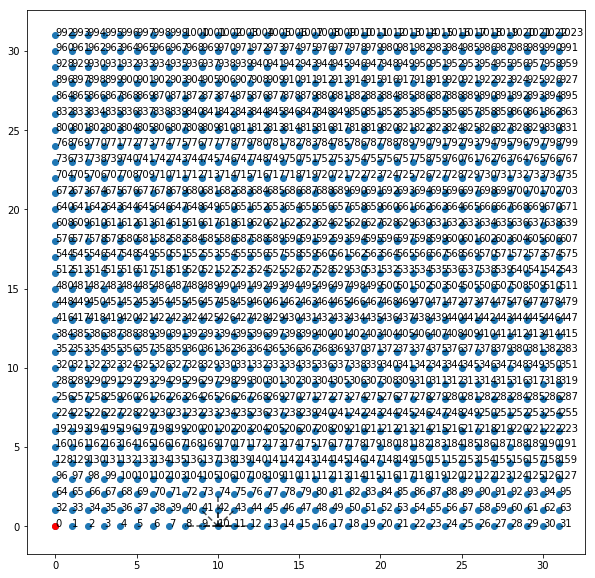

In [17]:
Probe.show(figwidth=10)

In [18]:
H = HSDetection(Probe, num_com_centers=1, threshold=threshold,
                maa=0, ahpthr=0, out_file_name=file_name,
                file_directory_name=file_directory, decay_filtering=True)

In [19]:
H.DetectFromRaw()

# Masking Channels: [0]
# Sampling rate: 23199
# Localization On
# Number of recorded channels: 1024
# Analysing frames: 3148820; Seconds: 135.73085046769256
# Frames before spike in cutout: 23
# Frames after spike in cutout: 51
# tcuts: 62 90
# tInc: 50000
# Analysing frames from -62 to 50090  (0.0%)
# Analysing frames from 49938 to 100090  (1.6%)
# Analysing frames from 99938 to 150090  (3.2%)
# Analysing frames from 149938 to 200090  (4.8%)
# Analysing frames from 199938 to 250090  (6.4%)
# Analysing frames from 249938 to 300090  (7.9%)
# Analysing frames from 299938 to 350090  (9.5%)
# Analysing frames from 349938 to 400090  (11.1%)
# Analysing frames from 399938 to 450090  (12.7%)
# Analysing frames from 449938 to 500090  (14.3%)
# Analysing frames from 499938 to 550090  (15.9%)
# Analysing frames from 549938 to 600090  (17.5%)
# Analysing frames from 599938 to 650090  (19.1%)
# Analysing frames from 649938 to 700090  (20.6%)
# Analysing frames from 699938 to 750090  (22.2%)
# Ana

In [20]:
H.LoadDetected()

Detected and read 295128 spikes.


Spike detected at channel:  966
Spike detected at frame:  295
Spike localised in position 5.949 30.105
trange (104,)
Data (104, 1024)


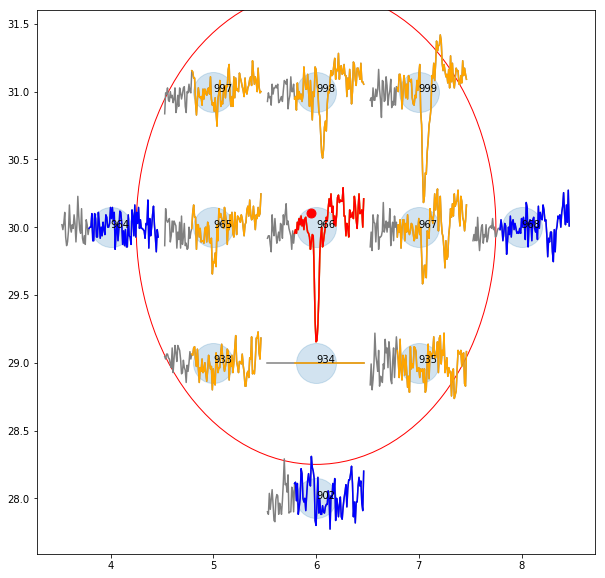

In [35]:
plt.figure(figsize=(10, 10))
H.PlotTracesChannels(10, window_size=105)

We have 295128 spikes, only showing 100000


(-1.551232078853047,
 32.551232078853054,
 -1.5512647167034586,
 32.55126471670346)

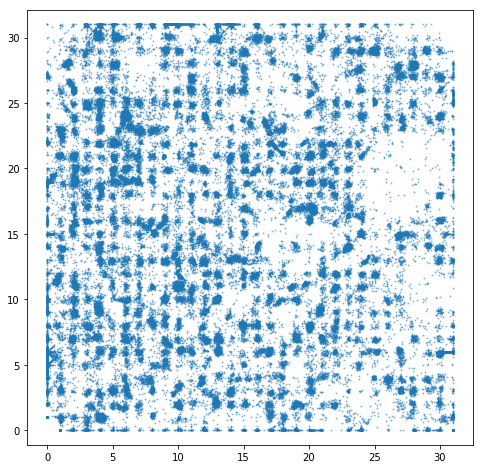

In [36]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
H.PlotAll(invert=True, s=1, alpha=0.4, ax=ax)
plt.axis('equal')

# Use of the `HSClustering` class

In [37]:
from herdingspikes.hs2 import HSClustering

In [38]:
# Load from file
#C = Clustering(['ProcessedSpikes_biocam.bin', 'ProcessedSpikes_biocam.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [39]:
%%time
C.ShapePCA(pca_ncomponents=2, pca_whiten=True)

Fitting PCA using 295128 spikes...
...projecting...
...done
CPU times: user 4.84 s, sys: 674 ms, total: 5.52 s
Wall time: 2.8 s


In [40]:
%%time
C.CombinedClustering(alpha=0.3, bandwidth=0.3, bin_seeding=False, n_jobs=-1, cluster_subset=100000)

Clustering...
Clustering using 100000 out of 295128 spikes...
number of seeds: 100000
seeds/job: 25001
using 4 cpus


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min finished


Number of estimated units: 5177
Predicting cluster labels for 295128 spikes...
predicting
CPU times: user 25.4 s, sys: 5.04 s, total: 30.4 s
Wall time: 4min 51s


We have 295128 spikes, only showing 100000


(-1.551232078853047,
 32.551232078853054,
 -1.5512647167034586,
 32.55126471670346)

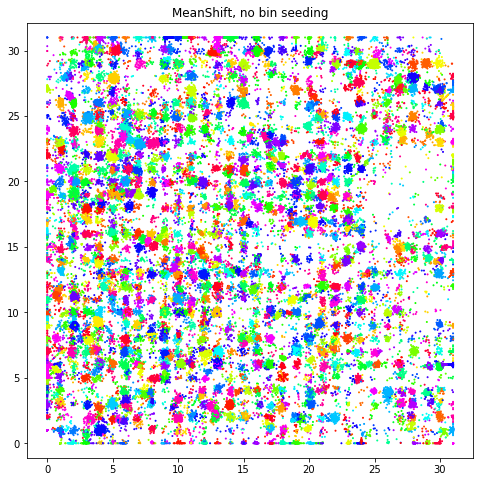

In [41]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
C.PlotAll(invert=True, s=1, ax=ax, max_show=100000,show_labels=False)
plt.title("MeanShift, no bin seeding");
plt.axis('equal')

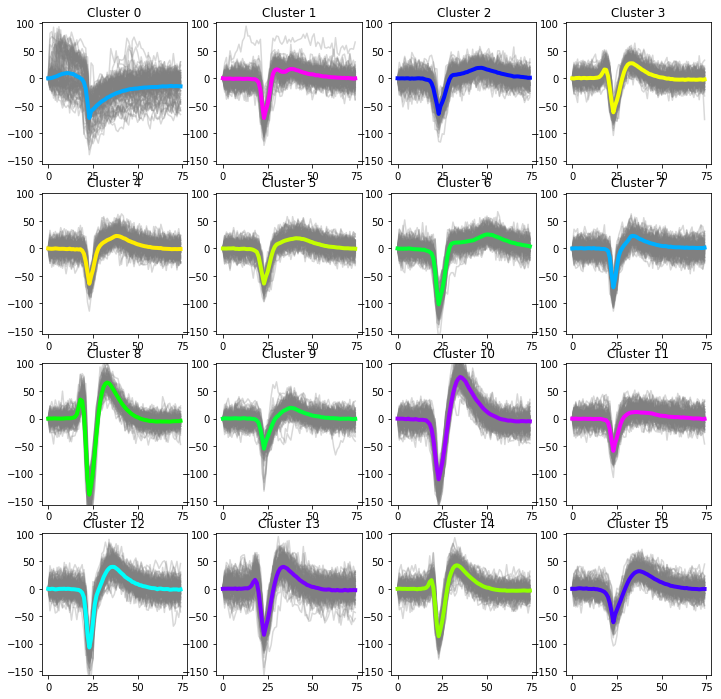

In [42]:
units = range(16)
C.PlotShapes(units)

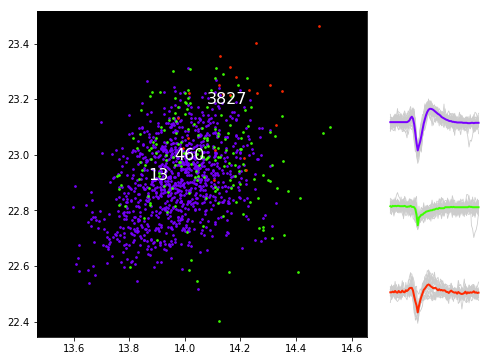

In [43]:
C.PlotNeighbourhood(13,radius=0.4, alpha=0.9);

In [44]:
C.SaveHDF5(file_name+"_sorted.hdf5")

# Warning: no sampling rate given, will be set to 0 in the hdf5 file.
